# Sentinel 3 OLCI - query and download data programatically

Here we look at ways to access the OLCI data programatically:

* Using the Dataspace API

* Using the `Openeo` package

The `sentinelsat` package is no longer compatible with the Copernicus Data Space Ecosystem (CDSE)

See example here for Sentinel-2 data: https://documentation.dataspace.copernicus.eu/notebook-samples/geo/odata_basics.html

See also: https://dataspace.copernicus.eu/news/2023-9-28-accessing-sentinel-mission-data-new-copernicus-data-space-ecosystem-apis

## Import necessary modules

In [1]:
# HTTP requests
import requests

# JSON parser
import json

# XML parser
import xml.etree.ElementTree as ET

# system modules
import os
import re
import sys
import random

# data manipulation
import pandas as pd
import numpy as np

# file manipulation
from pathlib import Path

In [2]:
# base URL of the product catalogue
catalogue_odata_url = "https://catalogue.dataspace.copernicus.eu/odata/v1"

# search parameters
collection_name = "SENTINEL-3"
product_type = "OL_1_EFR___" # OLCI, Level-1, full res., don't forget trailing underscores!
max_cloud_cover = 1
aoi = "POLYGON((-1.472415 44.251509,-1.472415 45.025411,-0.016726 45.025411,-0.016726 44.251509,-1.472415 44.251509))"
search_period_start = "2022-07-12T00:00:00.000Z"
search_period_end   = "2022-07-20T00:00:00.000Z"

search_query = f"{catalogue_odata_url}/Products?$filter=Collection/Name eq '{collection_name}' and Attributes/OData.CSC.StringAttribute/any(att:att/Name eq 'productType' and att/OData.CSC.StringAttribute/Value eq '{product_type}') and OData.CSC.Intersects(area=geography'SRID=4326;{aoi}') and ContentDate/Start gt {search_period_start} and ContentDate/Start lt {search_period_end}"
print(f"""\n{search_query.replace(' ', "%20")}\n""")


https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name%20eq%20'SENTINEL-3'%20and%20Attributes/OData.CSC.StringAttribute/any(att:att/Name%20eq%20'productType'%20and%20att/OData.CSC.StringAttribute/Value%20eq%20'OL_1_EFR___')%20and%20OData.CSC.Intersects(area=geography'SRID=4326;POLYGON((-1.472415%2044.251509,-1.472415%2045.025411,-0.016726%2045.025411,-0.016726%2044.251509,-1.472415%2044.251509))')%20and%20ContentDate/Start%20gt%202022-07-12T00:00:00.000Z%20and%20ContentDate/Start%20lt%202022-07-20T00:00:00.000Z



In [3]:
response = requests.get(search_query).json()
result = pd.DataFrame.from_dict(response["value"])
# print first results
result.head(3)

,@odata.mediaContentType,Id,Name,ContentType,ContentLength,OriginDate,PublicationDate,ModificationDate,Online,EvictionDate,S3Path,Checksum,ContentDate,Footprint,GeoFootprint
0,application/octet-stream,02ce9f2c-d71f-5bab-b1e4-69caa9de3617,S3B_OL_1_EFR____20220713T101511_20220713T10181...,application/octet-stream,0,2022-07-13T12:23:18.108000Z,2022-07-13T12:37:20.271730Z,2022-07-13T12:37:20.271730Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-3/OLCI/OL_1_EFR/2022/07/13/S3...,[],"{'Start': '2022-07-13T10:15:10.545000Z', 'End'...",geography'SRID=4326;POLYGON ((-8.52106 41.9831...,"{'type': 'Polygon', 'coordinates': [[[-8.52106..."
1,application/octet-stream,c11a73f5-b41a-5a84-9808-5d014a7b8f7b,S3B_OL_1_EFR____20220713T101511_20220713T10181...,application/octet-stream,0,2022-07-13T23:29:34.960000Z,2022-07-13T23:37:07.602390Z,2022-07-13T23:37:07.602390Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-3/OLCI/OL_1_EFR/2022/07/13/S3...,[],"{'Start': '2022-07-13T10:15:10.545000Z', 'End'...",geography'SRID=4326;POLYGON ((-8.52106 41.9831...,"{'type': 'Polygon', 'coordinates': [[[-8.52106..."
2,application/octet-stream,f87b6a0a-6153-5ede-91f1-c26bbb49a376,S3B_OL_1_EFR____20220716T103737_20220716T10403...,application/octet-stream,0,2022-07-16T23:30:14.342000Z,2022-07-16T23:33:56.597720Z,2022-07-16T23:33:56.597720Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-3/OLCI/OL_1_EFR/2022/07/16/S3...,[],"{'Start': '2022-07-16T10:37:37.353000Z', 'End'...",geography'SRID=4326;POLYGON ((-14.1326 41.9809...,"{'type': 'Polygon', 'coordinates': [[[-14.1326..."


# Load the data (requires authentication)

In [4]:
import os

username = ''
password = ''
# Write it here or use os.environ["CDSE_USERNAME"] etc to get it from your local environment

# Get authentication token
import certifi

auth_server_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
data = {
    "client_id": "cdse-public",
    "grant_type": "password",
    "username": username,
    "password": password,
}

response = requests.post(auth_server_url, data=data, verify=True, allow_redirects=False)
access_token = json.loads(response.text)["access_token"]

## Select the product and establish authenticated session

In this example we just grab the first item in the result list:

In [5]:
# Select identifier of the first product
product_identifier = result.iloc[0, 1]
product_name = result.iloc[0, 2]
print(product_name)
print(product_identifier)

S3B_OL_1_EFR____20220713T101511_20220713T101811_20220713T121520_0179_068_122_2160_PS2_O_NR_002.SEN3
02ce9f2c-d71f-5bab-b1e4-69caa9de3617


In [6]:
url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({product_identifier})/$value"

headers = {"Authorization": f"Bearer {access_token}"}

session = requests.Session()
session.headers.update(headers)
response = session.get(url, headers=headers, stream=True)

with open("product.zip", "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        if chunk:
            file.write(chunk)

We now have a ~635MB file in our local directory!

# Openeo

This package allows to easily query data, retrieving only the required channels and the required area. For the region visualised in this example, the whole data for three channels at seven epoches takes half a MB, while the original images are half a GB each!

In [7]:
import openeo
import xarray
import matplotlib.pyplot as plt

connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection

<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with NullAuth>

We are not connected yet. The next step opens a browser to give temporary access to the notebook:

In [8]:
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

## Query data

See example here for S2 data: https://documentation.dataspace.copernicus.eu/notebook-samples/openeo/Load_Collection.html

In [9]:
s3_cube = connection.load_collection(
    "SENTINEL3_OLCI_L1B",
    temporal_extent=("2022-07-12", "2022-07-19"),
    spatial_extent={
        "west": -1.27561,
        "south": 44.4935,
        "east": -0.979666,
        "north": 44.68714,
        "crs": "EPSG:4326",
    },
    bands=["B08", "B06", "B04"],
)

In [10]:
s3_cube.download("load-raw.nc")

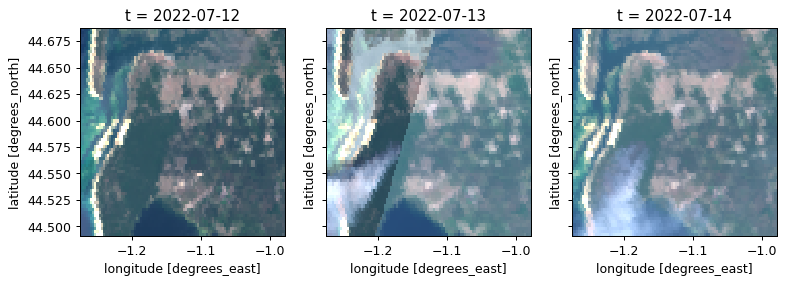

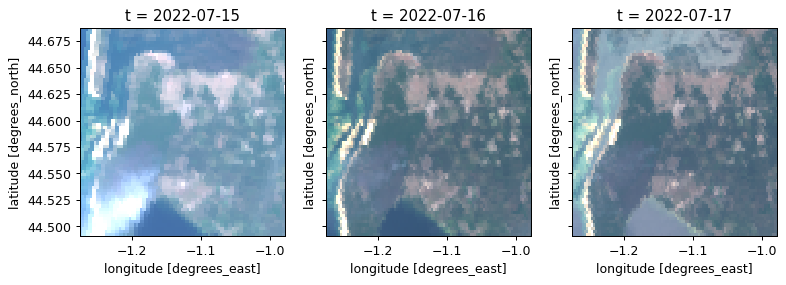

In [11]:
ds = xarray.load_dataset("load-raw.nc")
# Convert xarray DataSet to a (bands, t, x, y) DataArray
data = ds[["B08", "B06", "B04"]].to_array(dim="bands")


fig, axes = plt.subplots(ncols=3, figsize=(10, 3), dpi=90, sharey=True)
data[{"t": 0}].plot.imshow(ax=axes[0],vmin=0,vmax=0.2)
data[{"t": 1}].plot.imshow(ax=axes[1],vmin=0,vmax=0.2)
data[{"t": 2}].plot.imshow(ax=axes[2],vmin=0,vmax=0.2);

fig, axes = plt.subplots(ncols=3, figsize=(10, 3), dpi=90, sharey=True)
data[{"t": 3}].plot.imshow(ax=axes[0],vmin=0,vmax=0.2)
data[{"t": 4}].plot.imshow(ax=axes[1],vmin=0,vmax=0.2)
data[{"t": 5}].plot.imshow(ax=axes[2],vmin=0,vmax=0.2);

## Comparison with Sentinel 2

From the documentation: *"From the official documentation: The Level-2A processing includes a scene classification and an atmospheric correction applied to Top-Of-Atmosphere (TOA) Level-1C orthoimage products. Level-2A main output is an orthoimage Bottom-Of-Atmosphere (BOA) corrected reflectance product."*

In [1]:
import openeo
import xarray
import matplotlib.pyplot as plt

connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [6]:
s2_cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=("2022-07-05", "2022-07-18"),
    spatial_extent={
        "west": -1.27561,
        "south": 44.4935,
        "east": -0.979666,
        "north": 44.68714,
        "crs": "EPSG:4326",
    },
    bands=["B04", "B03", "B02"],
)

In [7]:
%%time
s2_cube.download("load-raw_S2.nc")

CPU times: user 772 ms, sys: 791 ms, total: 1.56 s
Wall time: 1min 15s


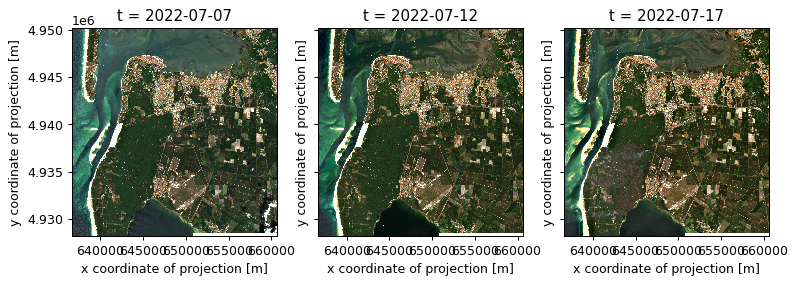

In [8]:
ds = xarray.load_dataset("load-raw_S2.nc")
# Convert xarray DataSet to a (bands, t, x, y) DataArray
data = ds[["B04", "B03", "B02"]].to_array(dim="bands")


fig, axes = plt.subplots(ncols=3, figsize=(10, 3), dpi=90, sharey=True)
data[{"t": 0}].plot.imshow(ax=axes[0],vmin=0,vmax=2000)
data[{"t": 1}].plot.imshow(ax=axes[1],vmin=0,vmax=2000)
data[{"t": 2}].plot.imshow(ax=axes[2],vmin=0,vmax=2000);

In [10]:
s2_cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=("2022-07-05", "2022-07-18"),
    spatial_extent={
        "west": -1.23,
        "south": 44.51,
        "east": -1.12,
        "north": 44.59,
        "crs": "EPSG:4326",
    },
    bands=["B04", "B03", "B02"],
)

s2_cube.download("load-raw_S2_zoom.nc")

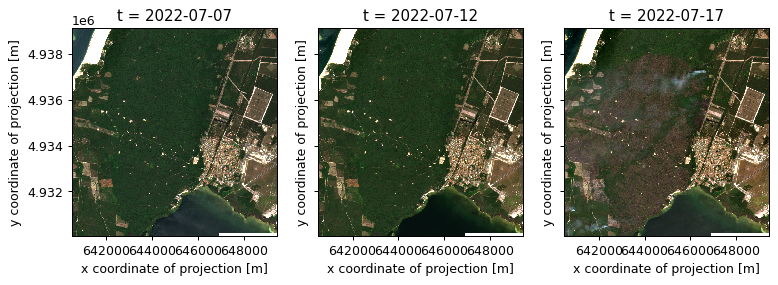

In [14]:
ds = xarray.load_dataset("load-raw_S2_zoom.nc")
# Convert xarray DataSet to a (bands, t, x, y) DataArray
data = ds[["B04", "B03", "B02"]].to_array(dim="bands")

fig, axes = plt.subplots(ncols=3, figsize=(10, 3), dpi=90, sharey=True)
data[{"t": 0}].plot.imshow(ax=axes[0],vmin=0,vmax=2000)
data[{"t": 1}].plot.imshow(ax=axes[1],vmin=0,vmax=2000)
data[{"t": 2}].plot.imshow(ax=axes[2],vmin=0,vmax=2000);